In [1]:
import time
import csv

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

In [2]:
# Choose dtype here:
np_dtype   = np.float32
cp_dtype   = cp.float32

In [3]:
def generate_random_batch(B, m, n, dtype=np_dtype):
    """
    Generate a batch of random matrices with shape (B, m, n).
    Supports real or complex dtypes.
    """
    if np.dtype(dtype).kind == 'c':  # complex
        real_part = np.random.randn(B, m, n).astype(dtype)
        imag_part = np.random.randn(B, m, n).astype(dtype)
        return real_part + 1j * imag_part
    else:
        return np.random.randn(B, m, n).astype(dtype)

In [4]:
def batched_svals_cupy(batch_cp: cp.ndarray) -> cp.ndarray:
    """
    Compute only the singular values of a batch of matrices on the GPU.
    Skips U and Vh via compute_uv=False.
    """
    # cp.linalg.svd on a stack returns a tuple-of-arrays only
    # when compute_uv=True.  For compute_uv=False it returns just the values.
    return cp.linalg.svd(batch_cp,
                         full_matrices=False,
                         compute_uv=False)

Warming up GPU…
B=   32 | time=0.000566s | avg_rel_error=4.01e-07
B=   64 | time=0.000648s | avg_rel_error=3.64e-07
B=  128 | time=0.000948s | avg_rel_error=3.48e-07
B=  256 | time=0.001436s | avg_rel_error=3.47e-07
B=  512 | time=0.002326s | avg_rel_error=3.29e-07
B= 1024 | time=0.004172s | avg_rel_error=3.42e-07
B= 2048 | time=0.007915s | avg_rel_error=3.47e-07
B= 4096 | time=0.015754s | avg_rel_error=3.55e-07
B= 8192 | time=0.030766s | avg_rel_error=3.53e-07
B=16384 | time=0.058224s | avg_rel_error=3.52e-07
Results saved to results_svals_cupy.csv


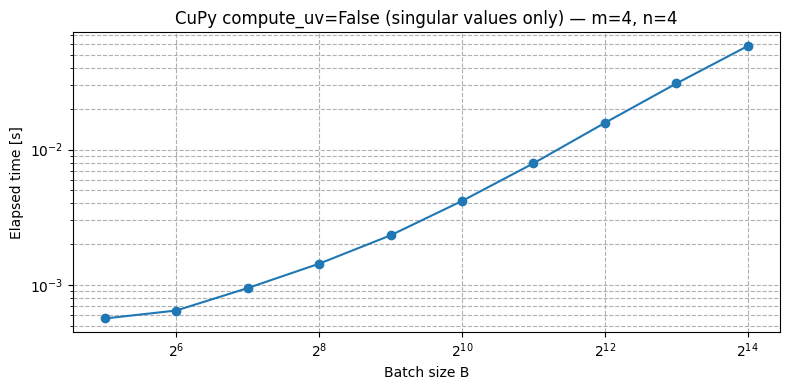

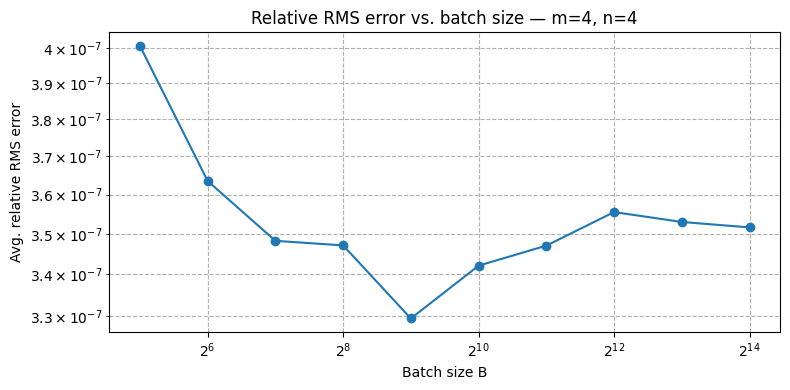

In [5]:
if __name__ == "__main__":
    # Matrix dimensions
    m, n = 4, 4
    batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

    # Warmup: one small batch
    print("Warming up GPU…")
    warm_batch = generate_random_batch(32, m, n)
    warm_cp    = cp.array(warm_batch, dtype=cp_dtype)
    S_warm     = batched_svals_cupy(warm_cp)
    cp.cuda.Device(0).synchronize() # Use synchronize() instead of block_until_ready()

    elapsed_times = []
    avg_errors    = []

    for B in batch_sizes:
        # 1) generate batch and transfer to device
        batch_np = generate_random_batch(B, m, n)
        batch_cp = cp.array(batch_np, dtype=cp_dtype)

        # 2) time the cuPy singular‐values only SVD
        start = time.time()
        S_cp  = batched_svals_cupy(batch_cp)
        cp.cuda.Device(0).synchronize() # Use synchronize() instead of block_until_ready()
        elapsed = time.time() - start
        elapsed_times.append(elapsed)

        # 3) compute reference singular values on CPU with NumPy
        # NumPy >=1.22 supports batched compute_uv=False directly
        S_ref = np.linalg.svd(batch_np, compute_uv=False)
        # If older NumPy returns tuple, slice out the second element:
        if isinstance(S_ref, tuple):
            S_ref = S_ref[1]

        # 4) error metric
        S_cp_np = S_cp.get()  # bring back to host
        rel_err = np.linalg.norm(S_cp_np - S_ref, axis=1) / np.linalg.norm(S_ref, axis=1)
        avg_err = rel_err.mean()
        avg_errors.append(avg_err)

        print(f"B={B:5d} | time={elapsed:.6f}s | avg_rel_error={avg_err:.2e}")

    # 5) save to CSV
    fname = "results_svals_cupy.csv"
    with open(fname, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["batch_size", "elapsed_time", "avg_rel_error"])
        for B, t, e in zip(batch_sizes, elapsed_times, avg_errors):
            writer.writerow([B, t, e])
    print(f"Results saved to {fname}")

    # 6) plot results
    B_arr = np.array(batch_sizes)
    t_arr = np.array(elapsed_times)
    e_arr = np.array(avg_errors)

    plt.figure(figsize=(8, 4))
    plt.plot(B_arr, t_arr, marker='o')
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.grid(True, which='both', ls='--')
    plt.title(f"CuPy compute_uv=False (singular values only) — m={m}, n={n}")
    plt.xlabel("Batch size B")
    plt.ylabel("Elapsed time [s]")
    plt.tight_layout()

    plt.figure(figsize=(8, 4))
    plt.plot(B_arr, e_arr, marker='o')
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.grid(True, which='both', ls='--')
    plt.title(f"Relative RMS error vs. batch size — m={m}, n={n}")
    plt.xlabel("Batch size B")
    plt.ylabel("Avg. relative RMS error")
    plt.tight_layout()

    plt.show()